<a href="https://colab.research.google.com/github/Adi502/Ingredients-Prediction/blob/main/Ingredients_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00


In [ ]:
import joblib
import pickle
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.despine()
import cv2
# from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.models import Model
%matplotlib inline


import math
from math import floor

<Figure size 432x288 with 0 Axes>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
imagePatches = glob('/content/drive/MyDrive/new_dataset/*/*', recursive=True)

In [ ]:
imagePatches[:10]

['/content/drive/MyDrive/new_dataset/Ras Malai/10_24.JPG',
 '/content/drive/MyDrive/new_dataset/Ras Malai/10_1.jpg',
 '/content/drive/MyDrive/new_dataset/Ras Malai/10_87.JPG',
 '/content/drive/MyDrive/new_dataset/Ras Malai/10_75.jpg',
 '/content/drive/MyDrive/new_dataset/Ras Malai/10_99.jpg',
 '/content/drive/MyDrive/new_dataset/Ras Malai/10_71.jpg',
 '/content/drive/MyDrive/new_dataset/Ras Malai/10_93.jpg',
 '/content/drive/MyDrive/new_dataset/Ras Malai/10_82.jpg',
 '/content/drive/MyDrive/new_dataset/Ras Malai/10_35.JPG',
 '/content/drive/MyDrive/new_dataset/Ras Malai/10_46.jpg']

In [ ]:
len(imagePatches)

1000

In [ ]:
x = []
y = []

WIDTH = 256
HEIGHT = 256

for img in imagePatches:
    filename = os.path.basename(img)
    label = int(filename.split('_')[0]) - 1
    y.append(label)


    full_size_image = cv2.imread(img)
    image_rgb = cv2.cvtColor(full_size_image, cv2.COLOR_BGR2GRAY)
    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))



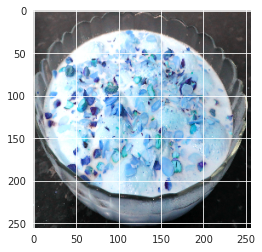

In [ ]:
plt.imshow(x[0])

In [ ]:
X=np.array(x)
X=X/255.0

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,  stratify=y,shuffle=True)

In [ ]:
Ytrain = pd.Series(Y_train)
Ytrain.value_counts()
# to show that the data is stratified

8    80
1    80
9    80
5    80
7    80
3    80
0    80
4    80
6    80
2    80
dtype: int64

In [ ]:
Ytest = pd.Series(Y_test)
Ytest.value_counts()
# to show that the data is stratified

9    20
5    20
4    20
7    20
6    20
0    20
1    20
8    20
3    20
2    20
dtype: int64

In [ ]:
#one hot encoding
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(Y_train)
y_testHot = to_categorical(Y_test)

In [ ]:
a = X_train
b = y_trainHot
c = X_test
d = y_testHot

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [ ]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plot_history(name):
  plt.figure(figsize=(20,6))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  #plt.clf()
  # summarize history for loss
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(name)
  plt.show()

def plot_matrix(modelname, name):
  y_pred=np.argmax(modelname.predict(c), axis=-1)
  con_mat = tf.math.confusion_matrix(labels=Y_test, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
  plt.figure(figsize=(9, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig(name)
  plt.show()


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

initial_model_res = ResNet50(include_top=False, input_shape=(256, 256, 3))

last = initial_model_res.output
	#print(last.shape)
x = Flatten()(last)
x = Dense(10, activation='softmax')(x)
model_res = Model(initial_model_res.input, x)

#Train only higher layers to avoid overfitting
for layer in model_res.layers[:15]:
	layer.trainable = False

    #Learning rate is changed to 0.001
adam = Adam(lr=1e-3, decay=1e-6)
model_res.compile(optimizer=adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

94765736/94765736 [==============================] - 3s 0us/step


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model_res.fit(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32,
                              epochs=25,
                              callbacks = [MetricsCheckpoint('logs')], validation_data = (c, d))

Epoch 1/25
25/25 [==============================] - 40s 664ms/step - loss: 9.6763 - accuracy: 0.1900 - val_loss: 59508.0117 - val_accuracy: 0.1000
Epoch 2/25
25/25 [==============================] - 16s 626ms/step - loss: 3.6342 - accuracy: 0.2438 - val_loss: 711.8014 - val_accuracy: 0.1000
Epoch 3/25
25/25 [==============================] - 16s 631ms/step - loss: 2.8789 - accuracy: 0.2763 - val_loss: 2.3024 - val_accuracy: 0.1000
Epoch 4/25
25/25 [==============================] - 16s 626ms/step - loss: 2.7298 - accuracy: 0.3537 - val_loss: 2.3026 - val_accuracy: 0.0800
Epoch 5/25
25/25 [==============================] - 15s 606ms/step - loss: 2.5171 - accuracy: 0.4050 - val_loss: 2.3037 - val_accuracy: 0.0950
Epoch 6/25
25/25 [==============================] - 15s 600ms/step - loss: 2.9734 - accuracy: 0.3262 - val_loss: 3.9199 - val_accuracy: 0.1100
Epoch 7/25
25/25 [==============================] - 15s 608ms/step - loss: 2.9593 - accuracy: 0.3025 - val_loss: 2.3335 - val_accuracy: 

In [ ]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
initial_model_vgg = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(256, 256, 3)
)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
from keras.models import Model

last = initial_model_vgg.output
	#print(last.shape)
x = Flatten()(last)
x = Dense(10, activation='softmax')(x)
model_vgg = Model(initial_model_vgg.input, x)

#Train only higher layers to avoid overfitting
for layer in model_vgg.layers[:6]:
	layer.trainable = False

    #Learning rate is changed to 0.001
adam = Adam(lr=1e-3, decay=1e-6)
model_vgg.compile(optimizer=adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])


In [ ]:
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
print(len(model_vgg.layers))

21


In [ ]:
history  = model_vgg.fit(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32,
                              epochs=25,
                              callbacks = [MetricsCheckpoint('logs')], validation_data = (c, d))

Epoch 1/25
25/25 [==============================] - 24s 681ms/step - loss: 2.5245 - accuracy: 0.0950 - val_loss: 2.3039 - val_accuracy: 0.1000
Epoch 2/25
25/25 [==============================] - 15s 594ms/step - loss: 2.3113 - accuracy: 0.1025 - val_loss: 2.3024 - val_accuracy: 0.1200
Epoch 3/25
25/25 [==============================] - 15s 589ms/step - loss: 2.3028 - accuracy: 0.1013 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/25
25/25 [==============================] - 17s 696ms/step - loss: 2.3027 - accuracy: 0.0862 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/25
25/25 [==============================] - 15s 597ms/step - loss: 2.3027 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/25
25/25 [==============================] - 15s 589ms/step - loss: 2.3028 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/25
25/25 [==============================] - 15s 600ms/step - loss: 2.3027 - accuracy: 0.1000 - val_loss: 2.3026 - val_accuracy: 0.1000

In [ ]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3

initial_model = InceptionV3(include_top=False, input_shape=(256, 256, 3))

last = initial_model.output
	#print(last.shape)
x = Flatten()(last)
x = Dense(10, activation='softmax')(x)
model_inc = Model(initial_model.input, x)

#Train only higher layers to avoid overfitting
for layer in model_inc.layers[:100]:
	layer.trainable = False

    #Learning rate is changed to 0.001
adam = Adam(lr=1e-3, decay=1e-6)
model_inc.compile(optimizer=adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
len(model_inc.layers)

313

In [ ]:
history = model_inc.fit(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32,
                              epochs=200,
                              callbacks = [MetricsCheckpoint('logs')], validation_data = (c, d))

Epoch 1/200
25/25 [==============================] - 33s 659ms/step - loss: 4.0367 - accuracy: 0.0988 - val_loss: 98804.5938 - val_accuracy: 0.0950
Epoch 2/200
25/25 [==============================] - 13s 529ms/step - loss: 2.5719 - accuracy: 0.0913 - val_loss: 11363.2988 - val_accuracy: 0.0950
Epoch 3/200
25/25 [==============================] - 13s 504ms/step - loss: 2.4780 - accuracy: 0.1138 - val_loss: 942.1161 - val_accuracy: 0.1000
Epoch 4/200
25/25 [==============================] - 12s 492ms/step - loss: 2.3676 - accuracy: 0.1863 - val_loss: 47.4142 - val_accuracy: 0.1050
Epoch 5/200
25/25 [==============================] - 13s 514ms/step - loss: 2.0428 - accuracy: 0.2713 - val_loss: 451.9215 - val_accuracy: 0.1000
Epoch 6/200
25/25 [==============================] - 13s 521ms/step - loss: 1.7503 - accuracy: 0.4712 - val_loss: 2244.3032 - val_accuracy: 0.1750
Epoch 7/200
25/25 [==============================] - 13s 523ms/step - loss: 1.6143 - accuracy: 0.5362 - val_loss: 1300.4

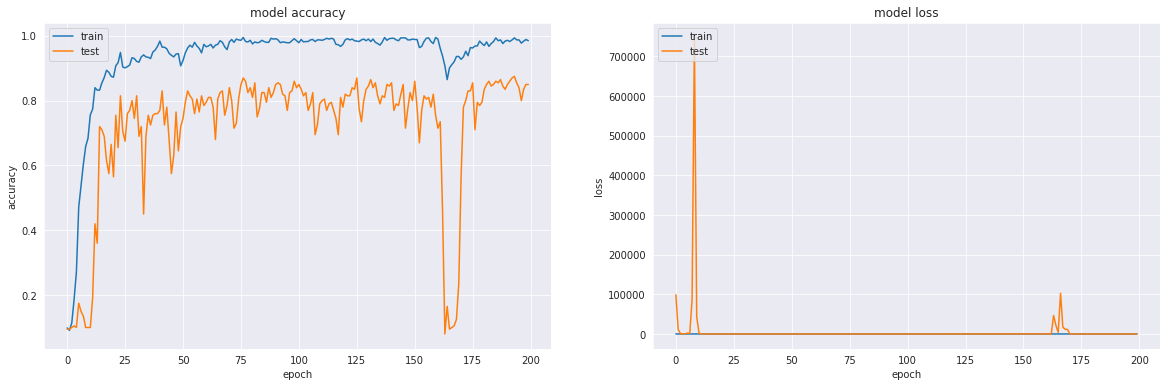

In [ ]:
plot_history('./Inception_loss_curve.png')

In [ ]:
plot_matrix(model_inc , './Inception_confusion_matrix.png')

7/7 [==============================] - 2s 96ms/step


NameError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
model_inc.save('/content/incv3')
with open("/content/history_wang_incv3", "wb") as fp:   #Pickling
  pickle.dump(history, fp)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......activation
.........vars
......activation_1
.........vars
......activation_10
.........vars
......activation_11
.........vars
......activation_12
.........vars
......activation_13
.........vars
......activation_14
.........vars
......activation_15
.........vars
......activation_16
.........vars
......activation_17
.........vars
......activation_18
.........vars
......activation_19
.........vars
......activation_2
.........vars
......activation_20
.........vars
......activation_21
.........vars
......activation_22
.........vars
......activation_23
.........vars
......activation_24
.........vars
......activation_25
.........vars
......activation_26
.........vars
......activation_27
.........vars
......activation_28
.........vars
......activation_29
.........vars
......activation_3
.........vars
......activation_30
.........vars
......activation_31
.........vars
......activation_32
.........vars
......activa

In [ ]:
incv3 = tf.keras.models.load_model('/content/incv3')

In [ ]:
accuracy = incv3.evaluate(c, d, verbose=1)
print('Test_Accuracy:-', accuracy[1])

7/7 [==============================] - 2s 90ms/step - loss: 1.1120 - accuracy: 0.8500
Test_Accuracy:- 0.8500000238418579
